# Predictive analysis of Bank Marketing

#### Problem Statement
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

#### What to achieve?
The classification goal is to predict if the client will subscribe a term deposit (variable y).

#### Data Contains information in following format:

### Categorical Variable :

* Marital - (Married , Single , Divorced)",
* Job - (Management,BlueCollar,Technician,entrepreneur,retired,admin.,services,selfemployed,housemaid,student,unemployed,unknown)
* Contact - (Telephone,Cellular,Unknown)
* Education - (Primary,Secondary,Tertiary,Unknown)
* Month - (Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec)
* Poutcome - (Success,Failure,Other,Unknown)
* Housing - (Yes/No)
* Loan - (Yes/No)
* Default - (Yes/No)

### Numerical Variable:

* Age
* Balance
* Day
* Duration
* Campaign
* Pdays
* Previous

#### Class
* deposit - (Yes/No)

In [2]:
#Importing required libraries
import pandas as pd
import numpy as np
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Importing and displaying data
data = pd.read_csv("bank.csv", delimiter=";",header='infer')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
#4521 rows and 17 features
data.shape

(4521, 17)

In [5]:
#datatypes of the columns
data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

Since the dtype contains types other than int, floot; we need to convert those column values into proper format in order to fit the data in model.

In [6]:
#Converting object type data into numeric type using One-Hot encoding method which is
#majorly used for XGBoost (for better accuracy) [Applicable only for non numeric categorical features]
data_new = pd.get_dummies(data, columns=['job','marital',
                                         'education','default',
                                         'housing','loan',
                                         'contact','month',
                                         'poutcome'])
#pd is instance of pandas. Using get_dummies method we can directly convert any type of data into One-Hot encoded format.

In [7]:
#Since y is a class variable we will have to convert it into binary format. (Since 2 unique class values)
data_new.y.replace(('yes', 'no'), (1, 0), inplace=True)

In [8]:
#Checking types of all the columns converted
data_new.dtypes

age                    int64
balance                int64
day                    int64
duration               int64
campaign               int64
pdays                  int64
previous               int64
y                      int64
job_admin.             uint8
job_blue-collar        uint8
job_entrepreneur       uint8
job_housemaid          uint8
job_management         uint8
job_retired            uint8
job_self-employed      uint8
job_services           uint8
job_student            uint8
job_technician         uint8
job_unemployed         uint8
job_unknown            uint8
marital_divorced       uint8
marital_married        uint8
marital_single         uint8
education_primary      uint8
education_secondary    uint8
education_tertiary     uint8
education_unknown      uint8
default_no             uint8
default_yes            uint8
housing_no             uint8
housing_yes            uint8
loan_no                uint8
loan_yes               uint8
contact_cellular       uint8
contact_teleph

In [9]:
#Our New dataframe ready for XGBoost
data_new.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,30,1787,19,79,1,-1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,33,4789,11,220,1,339,4,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,35,1350,16,185,1,330,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,30,1476,3,199,4,-1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,59,0,5,226,1,-1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1


In [10]:
#Spliting data as X -> features and y -> class variable
data_y = pd.DataFrame(data_new['y'])
data_X = data_new.drop(['y'], axis=1)
print(data_X.columns)
print(data_y.columns)

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')
Index(['y'], dtype='object')


In [11]:
#Dividing records in training and testing sets along with its shape (rows, cols)
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, random_state=2, stratify=data_y)
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(3164, 51)
(1357, 51)
(3164, 1)
(1357, 1)


In [12]:
#Create an XGB classifier and train it on 70% of the data set.
from sklearn import svm
from xgboost import XGBClassifier
clf = XGBClassifier()
clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

In [13]:
clf.fit(X_train, y_train)

c:\users\ziv\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\ziv\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\ziv\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[17:20:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
y_pred = clf.predict(X_test)
np.array(y_pred).shape
np.sum(y_pred.reshape([-1,1]) == np.array(y_test)) / len(y_pred)


0.8975681650700074

In [15]:
#classification accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.8975681650700074


**Using xgb Library**

In [16]:
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, random_state=2, stratify=data_y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [17]:
watchlist = [(dtrain, 'train'),(dtest, 'val')]
print(watchlist)

[(<xgboost.core.DMatrix object at 0x0000022BF2D68DC0>, 'train'), (<xgboost.core.DMatrix object at 0x0000022BF339FFD0>, 'val')]


In [18]:
#Train the model
params = {
    'objective':'multi:softprob',
#     'objective':'multi:mlogloss',
    'max_dept':4,
    'silent':1,
    'eta':0.3,
    'gamma': 0,
    'num_class': 2
}
num_rounds=20

In [19]:
XGB_Model = xgb.train(params,dtrain,num_rounds)

[17:20:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "max_dept", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:20:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
XGB_Model.dump_model('dump.rawBank.txt')

In [62]:
y_predict = XGB_Model.predict(dtest)

y_predict_assignment = np.argmax(y_predict, 1).reshape([-1,1])
test_acc = np.sum(y_predict_assignment == np.array(y_test)) / len(y_pred)
test_acc

0.89240972733972

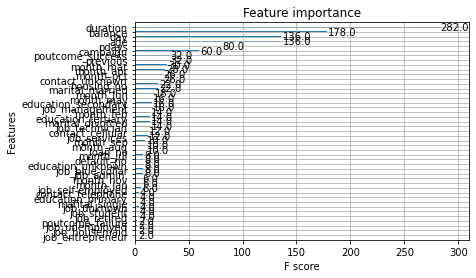

In [22]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(XGB_Model)
pyplot.show()

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

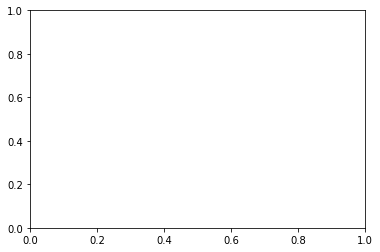

In [23]:
#Tree visualisation (Double tap to zoo)
xgb.plot_tree(XGB_Model, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

# Slicing

### HDR Age

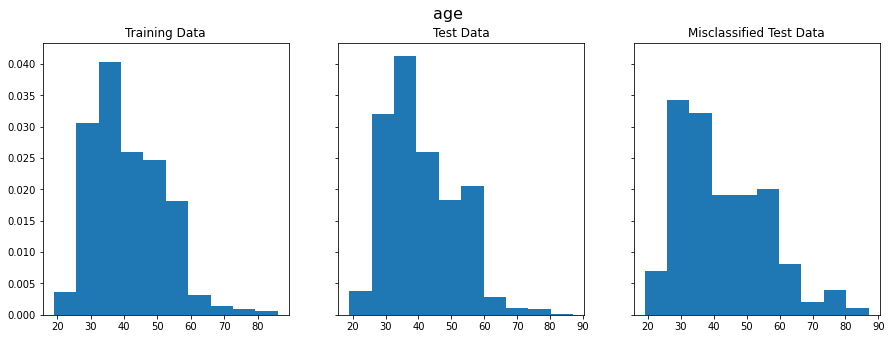

In [109]:
feature = 'age'
all_ages_train = np.array(X_train[feature])
all_ages_test = np.array(X_test[feature])
# extracting ages of misclasified test data
compare = np.argmax(y_predict,1) == np.array(df_y.values[:,1])
bad_guesses = np.where(compare == 0)[0]
bad_ages = np.array(X_test.iloc[bad_guesses][feature])

# plotting distribution of age
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

ax[0].set_title("Training Data")
ax[0].hist(all_ages_train, density=True)

ax[1].set_title("Test Data")
ax[1].hist(all_ages_test, density=True)

ax[2].set_title("Misclassified Test Data")
ax[2].hist(bad_ages, density=True)

fig.suptitle(feature, fontsize=16)
plt.show()

In [60]:
from sklearn.neighbors import KernelDensity
# finding hdr of misclassified age using kde
# bandwith and cutoff are parameters that can be played with
kde = KernelDensity(kernel="gaussian", bandwidth=.35).fit(bad_ages.reshape(-1,1))
log_dens = kde.score_samples(bad_ages.reshape(-1,1))

cutoff = -3
hdr_vals = bad_ages[np.where(log_dens>cutoff)]
hdr = [hdr_vals.min(), hdr_vals.max()]
hdr

[32, 46]

In [95]:
# generalized function for finding hdr of  feature among misclassified samples
def extract_hdr(df, feature, bandwidth=.35, cutoff=-3):

    feat_array = np.array(df[feature])

    kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(feat_array.reshape(-1,1))
    log_dens = kde.score_samples(feat_array.reshape(-1,1))

    cutoff = cutoff
    hdr_vals = feat_array[np.where(log_dens>cutoff)]
    if len(hdr_vals) > 0:
        hdr = [hdr_vals.min(), hdr_vals.max()]
    else:
        hdr = None
    return hdr

In [63]:
# comparing accuracy of test subset with age in hdr of misclassified samples vs overall test set accuracy
df_x = X_test.reset_index()
df_y = y_test.reset_index()

indexes = df_x.index[df_x[feature].between(hdr[0], hdr[1])]

ages_hdr_acc = np.sum(np.argmax(y_predict[indexes],1) == np.array(df_y.loc[indexes].values[:,1])) / len(indexes)

ages_hdr_acc, test_acc

(0.9107913669064748, 0.89240972733972)

In [160]:
# generalized function for comparing accuracy
def compare_acc(dfx, dfy, y_pred, sl):
    feat = sl[0][0]
    if sl[0][1] is None:
        indexes = np.arange(dfx.index[:][-1])
    elif type(sl[0][1]) == list:
        hdr_min, hdr_max = sl[0][1][0], sl[0][1][1]
        if hdr_min == hdr_max:
            indexes = dfx.index[dfx[feat] == hdr_min]
        else:
            indexes = dfx.index[dfx[feat].between(hdr_min, hdr_max)]
    else:
        indexes = dfx.index[dfx[feat] == sl[0][1]]
    test_acc = np.sum(np.argmax(y_pred,1) == np.array(dfy.values[:,1])) / len(y_pred)
    sub_acc = np.sum(np.argmax(y_pred[indexes],1) == np.array(dfy.loc[indexes].values[:,1])) / len(indexes)

    dif = test_acc - sub_acc
    
    return dif, sub_acc

### HDR General

In [88]:
# get list of all numeric feature slices
num_feats = []
for i, col in enumerate(data.dtypes):
    if np.issubdtype(col, np.integer):
        num_feats.append(data.columns[i])

num_feats

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [111]:
# for each numeric feature, extract hdr in misclassified test data
compare = np.argmax(y_predict,1) == np.array(df_y.values[:,1])
bad_guesses = X_test.iloc[np.where(compare == 0)[0]]

hdr_dict = {}
for feat in num_feats:
    hdr_dict[feat] = extract_hdr(bad_guesses, feat)

hdr_dict

{'age': [32, 46],
 'balance': [0, 0],
 'day': [2, 28],
 'duration': None,
 'campaign': [1, 4],
 'pdays': [-1, -1],
 'previous': [0, 2]}

In [124]:
from itertools import combinations
# generate slices
feats_and_vals = []
for feat in X_train.columns:
    # for numeric features only create slices in hdr
    if feat in num_feats:
        feats_and_vals.append([feat, hdr_dict[feat]])
    # for categorical features, create slices for each unique value
    else:
        for val in X_train[feat].unique():
            feats_and_vals.append([feat, val])

combos = list(combinations(feats_and_vals,1))
combos

[(['age', [32, 46]],),
 (['balance', [0, 0]],),
 (['day', [2, 28]],),
 (['duration', None],),
 (['campaign', [1, 4]],),
 (['pdays', [-1, -1]],),
 (['previous', [0, 2]],),
 (['job_admin.', 0],),
 (['job_admin.', 1],),
 (['job_blue-collar', 0],),
 (['job_blue-collar', 1],),
 (['job_entrepreneur', 0],),
 (['job_entrepreneur', 1],),
 (['job_housemaid', 0],),
 (['job_housemaid', 1],),
 (['job_management', 0],),
 (['job_management', 1],),
 (['job_retired', 0],),
 (['job_retired', 1],),
 (['job_self-employed', 0],),
 (['job_self-employed', 1],),
 (['job_services', 0],),
 (['job_services', 1],),
 (['job_student', 0],),
 (['job_student', 1],),
 (['job_technician', 1],),
 (['job_technician', 0],),
 (['job_unemployed', 0],),
 (['job_unemployed', 1],),
 (['job_unknown', 0],),
 (['job_unknown', 1],),
 (['marital_divorced', 0],),
 (['marital_divorced', 1],),
 (['marital_married', 0],),
 (['marital_married', 1],),
 (['marital_single', 1],),
 (['marital_single', 0],),
 (['education_primary', 0],),
 ([

In [161]:
# check accuracy of slices
df_x = X_test.reset_index()
df_y = y_test.reset_index()

sig = .02
prob_slices = []
for sl in combos:
    dif, acc = compare_acc(df_x, df_y, y_predict, sl)
    if dif > sig:
        prob_slices.append([sl, acc])

prob_slices

[[(['job_housemaid', 1],), 0.84375],
 [(['job_retired', 1],), 0.7536231884057971],
 [(['job_self-employed', 1],), 0.8571428571428571],
 [(['job_student', 1],), 0.75],
 [(['marital_married', 0],), 0.865530303030303],
 [(['marital_single', 1],), 0.8598901098901099],
 [(['housing_no', 1],), 0.8711864406779661],
 [(['housing_yes', 0],), 0.8711864406779661],
 [(['contact_cellular', 1],), 0.8717067583046965],
 [(['month_dec', 1],), 0.8333333333333334],
 [(['month_feb', 1],), 0.8082191780821918],
 [(['month_mar', 1],), 0.6428571428571429],
 [(['month_oct', 1],), 0.6666666666666666],
 [(['month_sep', 1],), 0.75],
 [(['poutcome_other', 1],), 0.7846153846153846],
 [(['poutcome_success', 1],), 0.8378378378378378],
 [(['poutcome_unknown', 0],), 0.8543307086614174]]